In [1]:
import numpy as np
from QAM_EncoderDecoder import * 
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from IPython.display import Audio
from scipy import interpolate, signal

%matplotlib inline

In [2]:
# constants

N = 2048
prefix_no = 256
fs = 44100

In [3]:

seed = 2021 # standardised across teams

rng = np.random.default_rng(seed)
length_random_sequence = N//2 -1
random_sequence = rng.integers(low=0, high=4, size=length_random_sequence)

mapping = {
    0:  1+1j,
    1: -1+1j,
    2: -1-1j,
    3:  1-1j
}

random_symbols = [mapping[r] for r in random_sequence]

In [4]:
def define_chirp(repeats=1):
    """returns standard log chirp waveform and its time-reverse"""
    
    sec = 1
    k = 1000
    w1 = 60
    w2 = 6000
    
    t = np.linspace(0, sec, int(fs*sec))
    
    chirp = np.sin(2*np.pi * w1 * sec * (np.exp( t * (np.log(w2 / w1) / sec)) -1) /np.log(w2 / w1) ) # log chirp
    chirp *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t))) / 5
    
    inv_chirp = np.flip(chirp) # have the inverse as a single chirp or the repeated chirps??
    chirp = np.tile(chirp, repeats)# / np.max(chirp)
    
    return chirp, inv_chirp

In [5]:
def ideal_channel_response(signal):
    """Returns channel output for tx signal"""
    
    channel = np.genfromtxt('channel.csv',delimiter=',')
    channel_op = np.convolve(signal, channel)
    
    return channel_op

def real_channel_response(signal):
    """Records and returns rx signal after writing to file"""
    
    wait_time = np.ceil(len(signal)/fs) + 1
    print("Recording for ", wait_time, " seconds")
    

    recording = sd.rec(int(wait_time * fs), samplerate=fs, channels=1)
    sd.wait()

    sf.write('sound_files/sync_long_rec.wav', recording, fs)

    print("Finished")
    recording = recording[:, 0]
    
    return recording  

In [6]:
def matched_filter(signal, match):
    """Returns convolution of signal with matched filter and its peak index"""
    
    convolution = np.convolve(signal, match)
    peak_index1 = np.argmax(np.abs(convolution[:len(convolution)//2])) # check 1st half of signal
    peak_index2 = np.argmax(np.abs(convolution[len(convolution)//2:])) + len(convolution)//2 # check 2nd half of signal
    
    return convolution, peak_index1, peak_index2

In [33]:
def data_to_OFDM(filename):
    
    bits_tran = file_to_bitstr(filename)
    symbols_tran = encode_bitstr2symbols(bits_tran)
    data_tran = symbol_to_OFDMframes(symbols_tran,N,prefix_no)
    data_tran = np.real(data_tran)
    
    return data_tran

def data_add_pilots(filename):
    
    seed = 2021 # standardised across teams

    rng = np.random.default_rng(seed)
    length_random_sequence = N//2 # need 511 extra symbols
    random_sequence = rng.integers(low=0, high=4, size=length_random_sequence)

    mapping = {
        0:  1+1j,
        1: -1+1j,
        2: -1-1j,
        3:  1-1j}

    frequency_filler = [mapping[r] for r in random_sequence]
    
    K = N//4 # so 512 info bins, might reduce in future
    P = K // 16
    pilotValue = 1 + 1j
    
    allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
    pilotCarriers = allCarriers[1::K//P] # Pilots are every (K//P)th carrier.
    dataCarriers = np.delete(allCarriers, pilotCarriers)
    dataCarriers = np.delete(dataCarriers, [0])
    
    data_bits = file_to_bitstr(filename)
    data_symbols= encode_bitstr2symbols(data_bits)

    carriers_required = int(np.ceil(len(data_symbols)/len(dataCarriers)))
    excess = int(len(dataCarriers) * carriers_required) - len(data_symbols)
    data_symbols = np.append(data_symbols, frequency_filler[:excess])
    print(carriers_required, excess, len(data_symbols), len(dataCarriers))

    OFDM_frames = []
    for i in range(0, carriers_required*len(dataCarriers), len(dataCarriers)):
        
        OFDM_symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
        OFDM_symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers
        OFDM_symbol[dataCarriers] = data_symbols[i:i+len(dataCarriers)]  # allocate the data subcarriers  
        OFDM_symbol = np.append(OFDM_symbol, frequency_filler[:N//2-K])
        OFDM_symbol = np.append(OFDM_symbol, np.append(0,np.conj(OFDM_symbol)[:0:-1]))
        OFDM_symbol = np.fft.ifft(OFDM_symbol)
        OFDM_symbol = np.append(OFDM_symbol[N-prefix_no:N], OFDM_symbol)   
        OFDM_symbol = np.real(OFDM_symbol)
        OFDM_frames.append(OFDM_symbol)   
        
    return OFDM_frames, [allCarriers, pilotCarriers, dataCarriers]  

def data_remove_pilots(all_frames, carrier_indices, channel_fft, filename):
    
    pilot_indices = carrier_indices[1]
    data_indices = carrier_indices[2]
    
    pilot_symbols = []
    data_symbols = []
    bits = ""
    for i in range(len(all_frames)):
        
        frame_no_cp = all_frames[i][prefix_no:]
        frame_dft = np.fft.fft(frame_no_cp)

        pilots = frame_dft[pilot_indices]
        data = frame_dft[data_indices]
        
        bits+=decode_symbols_2_bitstring(data, channel_fft[data_indices])
        
        pilot_symbols.append(pilots)
        data_symbols.append(data)
    
    bitstr_to_file(bits, filename)
    
    return data_symbols, pilot_symbols
    
    

In [8]:
def process_transmission(signal, start, length, offset=0):
    
    start += offset
    trimmed_frames = signal[start:start+length]
    split_frames = np.split(trimmed_frames, length/(N+prefix_no))
    
    average_frame = np.zeros(N+prefix_no)
    for frame in split_frames:     
        average_frame = np.add(average_frame, frame)
    average_frame /= (length/(N+prefix_no))
    
    return split_frames, average_frame

In [9]:
def estimate_channel_response(frame, known_frame):
    """Returns time and frequency channel impulse response from known OFDM symbols"""
    
    known_frame = known_frame[prefix_no:]
    frame = frame[prefix_no:] 
    
    known_symbols = np.fft.fft(known_frame, N)
    OFDM_symbol = np.fft.fft(frame, N)
    
    channel_freq_response = OFDM_symbol / known_symbols
    channel_freq_response[N//2] = 0 # avoid NaN error. error when not all bins filled, needs a fix
    channel_freq_response[0] = 0
    channel_imp_response = np.fft.ifft(channel_freq_response, N)
    channel_imp_response = np.real(channel_imp_response)
    
    return channel_freq_response, channel_imp_response

about to do symbol_to_OFDMframes encoding
symbol_to_OFDMframes encoding finished
about to do encode_bitstr2symbols encoding
encode_bitstr2symbols encoding finished
233 135 111607 479


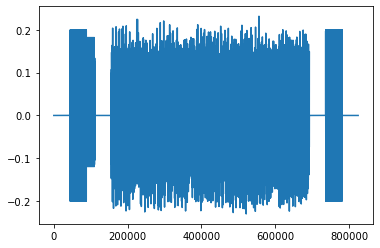

In [35]:
known_frame = symbol_to_OFDMframes(random_symbols, N, prefix_no)[0] # only 1 frame

ch, inv_ch = define_chirp(1)

#data_frames = data_to_OFDM('texttst.txt').ravel() # parallel to serial

data_frames, carrier_indices = data_add_pilots('texttst.txt')
data_frames = np.ravel(data_frames) # parallel to serial

repeats = 10 # standardised
gap = 1*fs

known_frames = np.tile(known_frame, repeats)

tx_signal = np.concatenate((np.zeros(gap), ch, known_frames, np.zeros(gap), data_frames, np.zeros(gap), ch, np.zeros(gap)), axis=None)

plt.plot(tx_signal)

filename = 'sound_files/transmit.wav'
sf.write(filename, tx_signal, fs)

In [36]:
# choose to test ideal or real channel

rx_signal = ideal_channel_response(tx_signal)    
#rx_signal = real_channel_response(tx_signal)

In [37]:
conv, peak_start, peak_end = matched_filter(rx_signal, inv_ch)

Actual sampling frequency:  44100.0


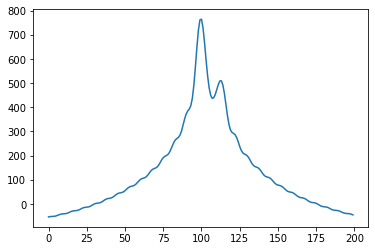

In [38]:
plt.plot(conv[peak_start-100:peak_start+100])

expected_ch_gap = len(known_frames) + 2*fs + len(data_frames) + len(ch)
actual_ch_gap = peak_end - peak_start

sampling_ratio = actual_ch_gap / expected_ch_gap

print("Actual sampling frequency: ", 44100*sampling_ratio)

824501


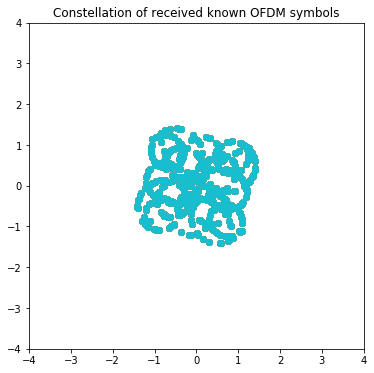

In [39]:
diff = 0 # variable

print(len(rx_signal))

all_frames, avg_frame = process_transmission(rx_signal, peak_start, len(known_frames), diff)

plt.figure(figsize=(6, 6))
for i in range(len(all_frames)):
    tst_symbols = np.fft.fft(all_frames[i][prefix_no:], N)[1:N//4]
    plt.scatter(np.real(tst_symbols), np.imag(tst_symbols), label=i)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.title('Constellation of received known OFDM symbols')

In [40]:

freq_response, imp_response = estimate_channel_response(avg_frame, known_frame)

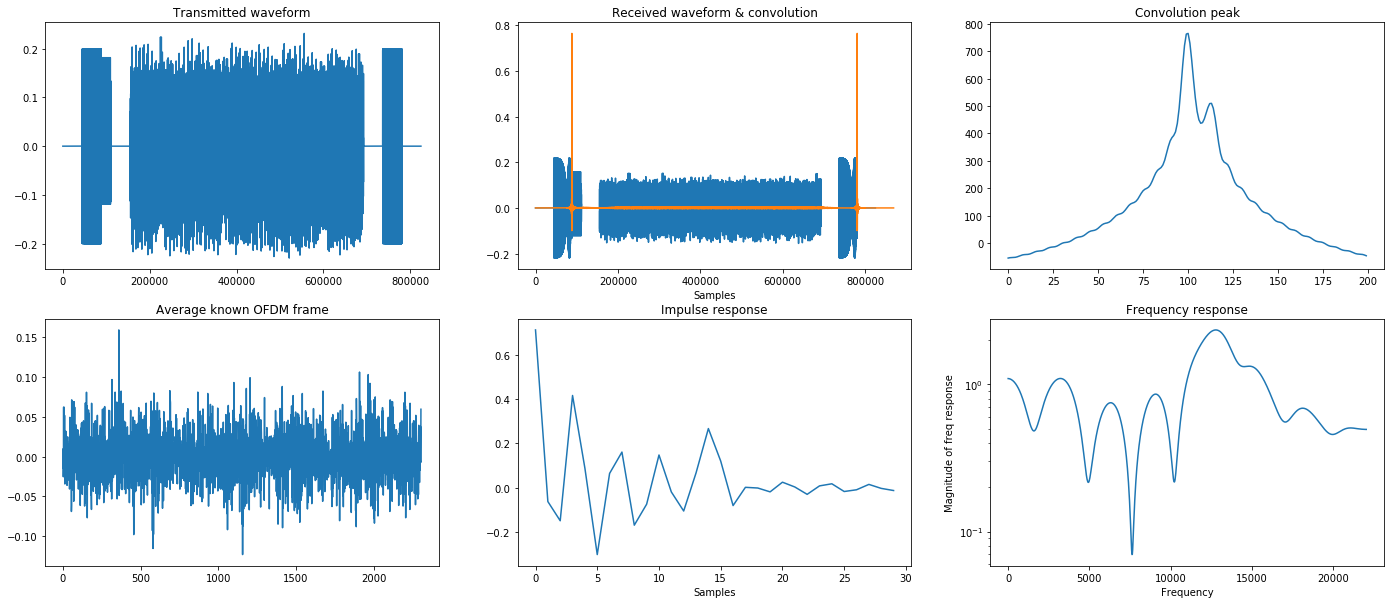

In [41]:
figs, axs = plt.subplots(2, 3, figsize=(24,10))
axs[0][0].plot(tx_signal)
axs[0][0].set_title('Transmitted waveform')
axs[0][1].plot(rx_signal)
axs[0][1].set_title('Received waveform & convolution')
axs[0][1].plot(conv/1000)
axs[0][1].set_xlabel('Samples')
axs[0][2].set_title('Convolution peak')
axs[0][2].plot(conv[peak_start-100:peak_start+100])

axs[1][0].set_title('Average known OFDM frame')
axs[1][0].plot(avg_frame)
axs[1][1].set_title('Impulse response')
axs[1][1].set_xlabel('Samples')
axs[1][1].plot(imp_response[:30])
axs[1][2].set_title('Frequency response')
axs[1][2].set_ylabel('Magnitude of freq response')
axs[1][2].set_xlabel('Frequency')
axs[1][2].semilogy(np.linspace(1, fs//2 -1, N//2-2), np.abs(freq_response[1:N//2-1]))

155340
536832


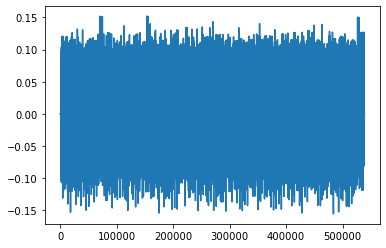

In [42]:
data_begin = peak_start + len(known_frames) + fs # include gap
print(data_begin)
print(len(data_frames))

rx_data_full = rx_signal[data_begin:data_begin+len(data_frames)]
rx_data_frames = np.split(rx_data_full, len(rx_data_full)/(N+prefix_no))

# carrier indices = [allCarriers, pilotCarriers, dataCarriers]

plt.plot(rx_signal[data_begin-1000:data_begin+len(data_frames)+1000])


In [46]:

rx_just_data, rx_just_pilots = data_remove_pilots(rx_data_frames, carrier_indices, freq_response, 'decoded_texttst.txt')
# these are data & pilot values before being divided by the channel fft

print(np.shape(rx_just_pilots))

bitstr written to  decoded_texttst.txt
(233, 32)


Text(0.5, 1.0, 'Received pilot constellation symbols')

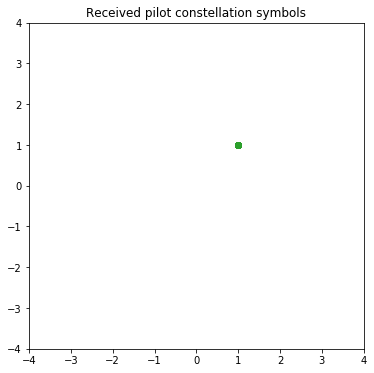

In [67]:
plt.figure(figsize=(6, 6))


for i in range(len(rx_just_pilots)):

    equalised_symbols = rx_just_pilots[i] / freq_response[carrier_indices[1]]
    e = 0.0 # get value from best fit of phase
    equalised_symbols *=  np.exp(-2*np.pi*1j*e*carrier_indices[1]/N)
    plt.scatter(np.real(equalised_symbols), np.imag(equalised_symbols), label=i)
        
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title('Received pilot constellation symbols')
#plt.legend()

(-4, 4)

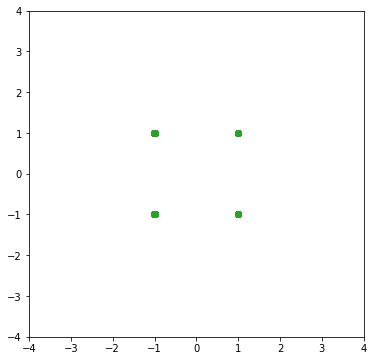

In [57]:
plt.figure(figsize=(6, 6))

for i in range(len(rx_just_data)):

    equalised_symbols = rx_just_data[i] / freq_response[carrier_indices[2]]
    e = 0.0 # get value from best fit of phase
    equalised_symbols *=  np.exp(-2*np.pi*1j*e*carrier_indices[2]/N)
    plt.scatter(np.real(equalised_symbols), np.imag(equalised_symbols), label=i)
        
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title('Received data constellation symbols')
#plt.legend()

(-200, 200)

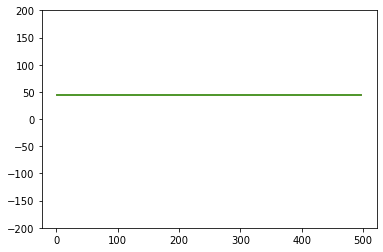

In [65]:
pilots_phase = np.unwrap(np.angle(rx_just_pilots / freq_response[carrier_indices[1]]))

for i in range(len(pilots_phase)):
    plt.plot(carrier_indices[1], 180*pilots_phase[i]/np.pi, label=i)
    
plt.ylim(-200, 200)
#plt.legend()